In [1]:
# Deepfake Authentication using AI algorithms built from scratch
# Works fully offline in Python 3.14 (Windows)

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns


In [2]:
def show_image(img, title=''):
    plt.figure(figsize=(3,3))
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')


In [3]:
# Paths (make sure dataset folders exist)
REAL_DIR = "dataset/real"
FAKE_DIR = "dataset/fake"
IMG_SIZE = (64, 64)

def load_images(folder, label, max_files=None):
    X, y = [], []
    files = os.listdir(folder)
    if max_files:
        files = files[:max_files]
    for file in files:
        try:
            img_path = os.path.join(folder, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, IMG_SIZE)
            X.append(img)
            y.append(label)
        except:
            continue
    return X, y

X_real, y_real = load_images(REAL_DIR, 0, max_files=200)
X_fake, y_fake = load_images(FAKE_DIR, 1, max_files=200)

print("Loaded:", len(X_real), "real and", len(X_fake), "fake images.")


Loaded: 200 real and 200 fake images.


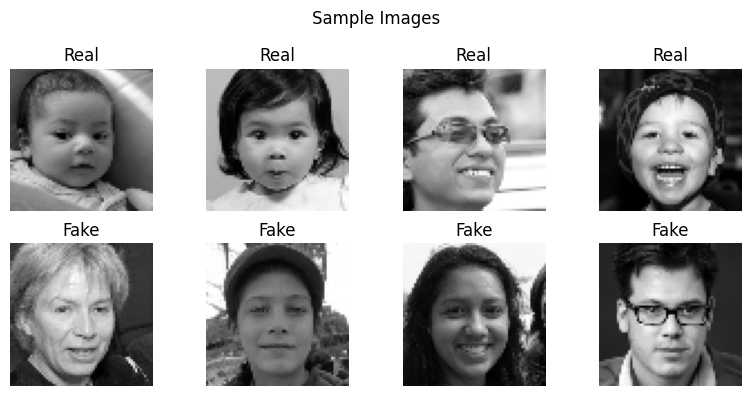

In [4]:
plt.figure(figsize=(8,4))
for i in range(4):
    plt.subplot(2,4,i+1)
    plt.imshow(X_real[i], cmap='gray')
    plt.title("Real")
    plt.axis('off')
    plt.subplot(2,4,i+5)
    plt.imshow(X_fake[i], cmap='gray')
    plt.title("Fake")
    plt.axis('off')
plt.suptitle("Sample Images")
plt.tight_layout()
plt.show()


In [5]:
def lbp_image(img):
    rows, cols = img.shape
    lbp = np.zeros((rows-2, cols-2), dtype=np.uint8)
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            center = img[i, j]
            binary = 0
            binary |= (1 << 0) if img[i-1, j-1] >= center else 0
            binary |= (1 << 1) if img[i-1, j  ] >= center else 0
            binary |= (1 << 2) if img[i-1, j+1] >= center else 0
            binary |= (1 << 3) if img[i  , j+1] >= center else 0
            binary |= (1 << 4) if img[i+1, j+1] >= center else 0
            binary |= (1 << 5) if img[i+1, j  ] >= center else 0
            binary |= (1 << 6) if img[i+1, j-1] >= center else 0
            binary |= (1 << 7) if img[i  , j-1] >= center else 0
            lbp[i-1, j-1] = binary
    return lbp

def extract_features(img):
    # 1️⃣ Edge detection
    edges = cv2.Canny(img, 100, 200)
    edge_feat = cv2.resize(edges, (8,8)).flatten() / 255.0

    # 2️⃣ Intensity histogram
    hist = cv2.calcHist([img], [0], None, [16], [0,256]).flatten()
    hist = hist / (np.sum(hist) + 1e-6)

    # 3️⃣ LBP texture
    lbp = lbp_image(img)
    lbp_hist, _ = np.histogram(lbp.flatten(), bins=16, range=(0,256))
    lbp_hist = lbp_hist / (np.sum(lbp_hist) + 1e-6)

    # Combine all features
    features = np.concatenate([edge_feat, hist, lbp_hist])
    return features


In [6]:
X = X_real + X_fake
y = y_real + y_fake

features = []
for img in tqdm(X, desc="Extracting Features"):
    features.append(extract_features(img))

X_features = np.array(features)
y = np.array(y)

print("Feature matrix shape:", X_features.shape)


Extracting Features: 100%|███████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 54.12it/s]

Feature matrix shape: (400, 96)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42, stratify=y
)
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 320
Testing samples: 80


In [8]:
class LogisticRegressionScratch:
    def __init__(self, lr=0.1, epochs=1000, verbose=False):
        self.lr = lr
        self.epochs = epochs
        self.verbose = verbose

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.W = np.zeros(n_features)
        self.b = 0
        for epoch in range(self.epochs):
            linear = np.dot(X, self.W) + self.b
            y_pred = self.sigmoid(linear)
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = np.mean(y_pred - y)
            self.W -= self.lr * dw
            self.b -= self.lr * db
            if self.verbose and epoch % 100 == 0:
                loss = -np.mean(y*np.log(y_pred+1e-9) + (1-y)*np.log(1-y_pred+1e-9))
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        y_pred = self.sigmoid(np.dot(X, self.W) + self.b)
        return np.where(y_pred >= 0.5, 1, 0)


In [9]:
model = LogisticRegressionScratch(lr=0.5, epochs=1200, verbose=True)
model.fit(X_train, y_train)
print("✅ Training completed.")


Epoch 0, Loss: 0.6931
Epoch 100, Loss: 0.6085
Epoch 200, Loss: 0.5838
Epoch 300, Loss: 0.5722
Epoch 400, Loss: 0.5653
Epoch 500, Loss: 0.5606
Epoch 600, Loss: 0.5571
Epoch 700, Loss: 0.5543
Epoch 800, Loss: 0.5520
Epoch 900, Loss: 0.5500
Epoch 1000, Loss: 0.5482
Epoch 1100, Loss: 0.5467
✅ Training completed.


Model Accuracy: 62.50%
              precision    recall  f1-score   support

        Real       0.61      0.70      0.65        40
        Fake       0.65      0.55      0.59        40

    accuracy                           0.62        80
   macro avg       0.63      0.62      0.62        80
weighted avg       0.63      0.62      0.62        80



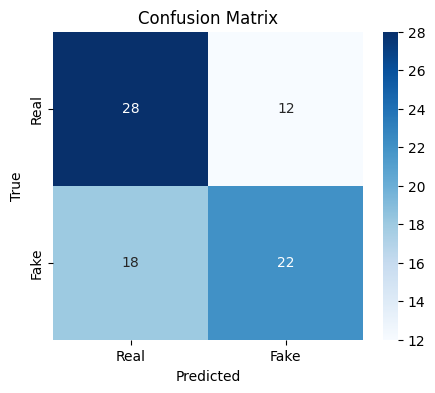

In [10]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {acc*100:.2f}%")
print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real","Fake"], yticklabels=["Real","Fake"])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()


In [11]:
def predict_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMG_SIZE)
    feat = extract_features(img)
    pred = model.predict([feat])[0]
    show_image(img, title="Predicted: " + ("FAKE" if pred==1 else "REAL"))
    print("Prediction:", "FAKE" if pred==1 else "REAL")

# Example usage:
# predict_image("dataset/fake/yourimage.jpg")


In [12]:
np.savez("deepfake_model.npz", W=model.W, b=model.b)
print("Model saved successfully.")


Model saved successfully.


In [13]:
import numpy as np
data = np.load('deepfake_model.npz')
print(list(data.keys()))
W, b = data['W'], data['b']
print("Loaded model:", W.shape, b)


['W', 'b']
Loaded model: (96,) 1.1014929376432128


In [ ]:
#test

In [17]:
def predict_with_saved_model(img_path):
    import cv2
    import numpy as np
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64,64))
    feat = extract_features(img)
    linear = np.dot(feat, W) + b
    pred = 1 / (1 + np.exp(-linear))
    label = "Fake" if pred >= 0.5 else "Real"
    print("Prediction:", label, "| Score:", float(pred))


In [21]:
path = r"C:\Users\Acer\deepfake_auth_project\IMG_3.JPG"
print("Exists:", os.path.exists(path))

Exists: True


In [22]:
predict_with_saved_model(r"C:\Users\Acer\deepfake_auth_project\IMG_3.JPG")

Prediction: Real | Score: 0.21916646575259768


In [23]:
predict_with_saved_model(r"C:\Users\Acer\Downloads\testimgai.jpg")

Prediction: Fake | Score: 0.6519841711599916


In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_with_report(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("❌ Error: Could not load image. Check the file path.")
        return
    
    img_resized = cv2.resize(img, (64, 64))

    # Extract features
    feat = extract_features(img_resized)

    # Compute prediction manually
    linear = np.dot(feat, W) + b
    pred = 1 / (1 + np.exp(-linear))
    label = "Fake" if pred >= 0.5 else "Real"
    confidence = float(pred if pred >= 0.5 else 1 - pred)

    # Generate feature visuals
    edges = cv2.Canny(img_resized, 100, 200)
    lbp = lbp_image(img_resized)
    hist = cv2.calcHist([img_resized],[0],None,[16],[0,256]).flatten()
    hist = hist / (np.sum(hist)+1e-6)

    # 🧾 Report Display
    print(f"🧠 Prediction Report for: {img_path}")
    print("-"*60)
    print(f"✅ Classified as: {label}")
    print(f"📊 Confidence: {confidence*100:.2f}%")
    print("-"*60)
    if label == "Fake":
        print("🔍 Explanation: The texture and edge patterns show unusual uniformity,")
        print("likely due to AI generation smoothing or lighting inconsistencies.")
        print("Histogram patterns may lack natural high-frequency noise found in real faces.")
    else:
        print("🔍 Explanation: The texture and edge structures appear natural,")
        print("with diverse lighting and fine-grain skin features typical of real images.")
    print("-"*60)

    # 🖼️ Visualize image and analysis
    plt.figure(figsize=(12,6))

    plt.subplot(2,3,1)
    plt.imshow(img_resized, cmap='gray')
    plt.title(f"Original ({label})")
    plt.axis('off')

    plt.subplot(2,3,2)
    plt.imshow(edges, cmap='gray')
    plt.title("Edge Detection")

    plt.subplot(2,3,3)
    plt.imshow(lbp, cmap='gray')
    plt.title("Local Binary Pattern")

    plt.subplot(2,3,5)
    plt.plot(hist, color='blue')
    plt.title("Intensity Histogram")
    plt.xlabel("Pixel Value Bins")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()


🧠 Prediction Report for: C:\Users\Acer\Downloads\testimgai.jpg
------------------------------------------------------------
✅ Classified as: Fake
📊 Confidence: 65.20%
------------------------------------------------------------
🔍 Explanation: The texture and edge patterns show unusual uniformity,
likely due to AI generation smoothing or lighting inconsistencies.
Histogram patterns may lack natural high-frequency noise found in real faces.
------------------------------------------------------------


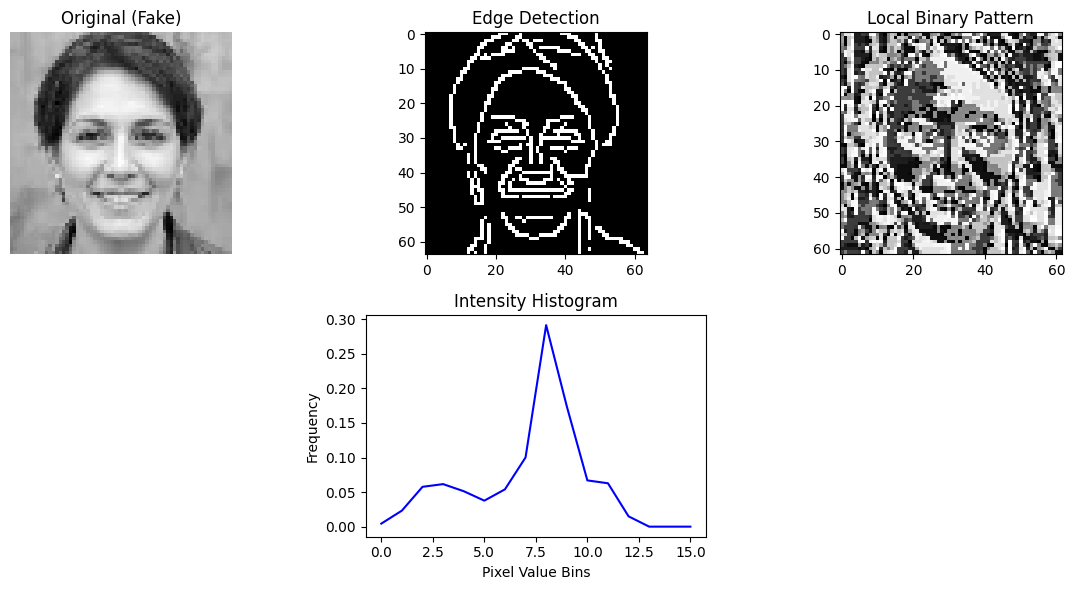

In [25]:
predict_with_report(r"C:\Users\Acer\Downloads\testimgai.jpg")

🧠 Prediction Report for: C:\Users\Acer\deepfake_auth_project\IMG_3.JPG
------------------------------------------------------------
✅ Classified as: Real
📊 Confidence: 78.08%
------------------------------------------------------------
🔍 Explanation: The texture and edge structures appear natural,
with diverse lighting and fine-grain skin features typical of real images.
------------------------------------------------------------


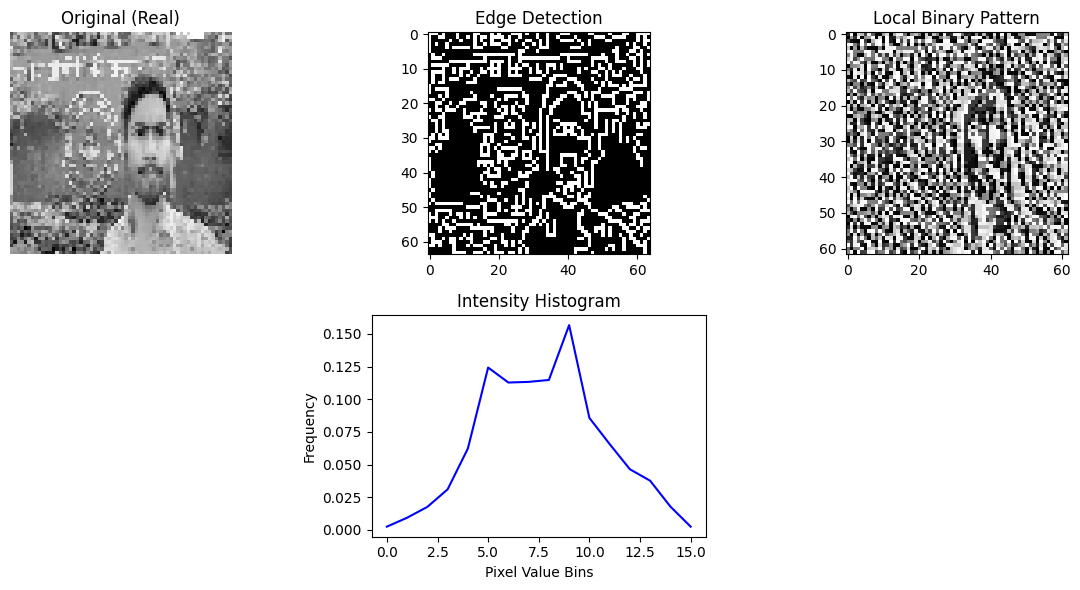

In [26]:
predict_with_report(r"C:\Users\Acer\deepfake_auth_project\IMG_3.JPG")